In [1]:
import sys
import os
import pandas as pd
from pytablewriter import MarkdownTableWriter
from typing import Dict, List, Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

%config Completer.use_jedi = False


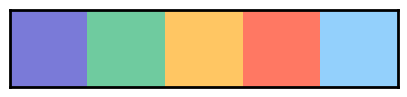

In [2]:

sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("paper", font_scale=1.5)

plt.rcParams.update({'axes.edgecolor': 'black', 'axes.linewidth': 2, 
                     'axes.grid': False, 'grid.linestyle': '--'})
colors = ['#7a7ad8', '#6fcb9f', '#ffc663', '#ff7863', '#93d0fc']
sns.palplot(colors)
sns.set_palette(sns.color_palette(colors), 8, .75)
sub_figure_title = {"fontweight": 700, 'fontname':'Arial', 'fontsize': 18}
#plt.tight_layout()


In [3]:
#ALGORITHM = ["semantic-zest", "syntactic-zest", "semantic-noguidance", "syntactic-noguidance"]
ALGORITHM = ["semantic-zest", "syntactic-zest", "semantic-noguidance", "syntactic-noguidance","afl"]

RANGE=20 #exclusiove range in python


In [4]:
#path = "/home/alena/source/growe/exps8"

folder = "expfinalfinal"
base_path = f"c:\\Users\\Alena\\source\\repos\\growe\\{folder}\\"


In [5]:

def process_cov_data(path: str) -> List[str]:
    with open(path) as f:
        return f.readlines()

def add_rolling_mean( data : pd.DataFrame, rolling : int = 10) -> pd.DataFrame:
    
    # rolling mean to valid_covered_probes
    data[f'rolling_{rolling}_valid_covered_probes'] = data['valid_covered_probes'].rolling(rolling).mean()
    
    # rolling mean to all_covered_probes
    data[f'rolling_{rolling}_all_covered_probes'] = data['all_covered_probes'].rolling(rolling).mean()
    
    # rolling mean to total_inputs
    data[f'rolling_{rolling}_total_inputs'] = data['total_inputs'].rolling(rolling).mean()

    data['rolling_algorithm'] = data['algorithm'].astype(str) + f"_rollingmean_{rolling}"
    
    return data

In [6]:
def read_plot_data(path: str, algorithm: str, idx: int) -> pd.DataFrame:
    ps=os.path.join(path, 'plot_data')
    #print(ps)
    time_axis = "# unix_time"
    if algorithm == "afl":
        data = pd.read_csv(ps, sep=",", skipinitialspace=True,
                       converters={"valid_cov": p2f, "map_size": p2f})
    else:
        data = pd.read_csv(ps, sep=",", skipinitialspace=True)

    if data.empty: return None

    data[time_axis] -= data[time_axis][0]
    data['total_inputs'] = data['valid_inputs'] + data['invalid_inputs']
    data['total_inputs'] -= data["total_inputs"][0]
    
    #data = data[data[time_axis] < threshhold]

    x_axis = time_axis
    algo_data = data.copy().drop_duplicates(
        keep='first', subset=[x_axis])
    
    algo_data['algorithm'] = [algorithm] * algo_data.shape[0]
    algo_data['run'] = [idx] * algo_data.shape[0]
  
    return algo_data


In [7]:
# READ ORIGIANL DATA

original_plot_data=[] # array of original dataframes

for algorithm in ALGORITHM:
    original_data_per_algo = []

    for idx in range(0, RANGE):
        path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}", "errorDir")
        if algorithm == "afl":
            path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}","fuzz-results")
        if not os.path.exists(path):
            continue
        #print(f"processing: {path}")

        # plot_data from jqf afl run differs from other 
        if not algorithm == "afl" and os.path.exists(os.path.join(path,"plot_data")): 
            original_data = read_plot_data(path,algorithm,idx)
            if original_data is None:
                continue

            original_data_per_algo.append(original_data)
        
    original_plot_data.extend([d for d in original_data_per_algo])



In [8]:

def read_exception_log(path: str, algorithm: str) -> pd.DataFrame:
    ps=os.path.join(path, 'exception_log.csv')
    #print(ps)
    columns=["exception","unique","count","file","empty"]
    if algorithm != "afl":
        data = pd.read_csv(ps, sep=";", header=None,names=columns)

    if data.empty: return None
    
    data['algorithm'] = [algorithm] * data.shape[0]
  
    return data


In [9]:
# READ Exceptions

exceptions_data = []
exceptions_per_algo = []

for algorithm in ALGORITHM:
    
    for idx in range(0, RANGE):
        path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}", "errorDir")
        if not os.path.exists(path):
            continue
        #print(f"processing: {path}")
        if not algorithm == "afl" and os.path.exists(os.path.join(path,"exception_log.csv")): 
            exc = read_exception_log(path,algorithm)
            if exc is None:
                continue

            exceptions_per_algo.append(exc)
            
exceptions_data = pd.concat(exceptions_per_algo)


In [10]:
exceptions_data


,exception,unique,count,file,empty,algorithm
0,nextflow.exception.AbortRunException,True,1,out1694866706209.nf,NaN,semantic-zest
1,nextflow.exception.ScriptCompilationException,True,1,out1694866721541.nf,NaN,semantic-zest
0,nextflow.exception.AbortRunException,True,1,out1694871604172.nf,NaN,semantic-zest
0,nextflow.exception.AbortRunException,True,1,out1694876431971.nf,NaN,semantic-zest
1,nextflow.exception.ScriptCompilationException,True,1,out1694876468216.nf,NaN,semantic-zest
...,...,...,...,...,...,...
1908,groovy.lang.MissingPropertyException,True,1382,out1694992074735.nf,NaN,syntactic-noguidance
1909,groovy.lang.MissingPropertyException,True,1383,out1694992078658.nf,NaN,syntactic-noguidance
1910,nextflow.exception.ScriptCompilationException,True,418,out1694992080841.nf,NaN,syntactic-noguidance
1911,groovy.lang.MissingPropertyException,True,1384,out1694992084580.nf,NaN,syntactic-noguidance


In [11]:
# interpolated data

reindexsteps = 4 

time_based_plot_data = [] #dataframe with interpolated runs 
count_based_plot_data = [] #dataframe with interpolated runs

first_idx=0

for df in original_plot_data:
    algorithm = df['algorithm'][0]
    
    x_axis = "# unix_time"
    time_based_data = df.copy().drop_duplicates(
        keep='first', subset=[x_axis])
    
    time_based_data = time_based_data.set_index(x_axis).reindex(
       range(1, time_based_data[x_axis].max(), reindexsteps)).interpolate().reset_index()
    
    #resetting algo because it was overwritten by interpolation
    time_based_data['algorithm'] = [algorithm] * time_based_data.shape[0]
    time_based_plot_data.append( time_based_data)

    
    x_axis = "total_inputs"
    count_based_data = df.copy().drop_duplicates(
        keep='first', subset=[x_axis])
    
    count_based_data = count_based_data.set_index(x_axis).reindex(
       range(0, count_based_data[x_axis].max(), reindexsteps)).interpolate().reset_index()
    #resetting algo because it was overwritten by interpolation
    count_based_data['algorithm'] = [algorithm] * count_based_data.shape[0]
    
    count_based_plot_data.append(count_based_data)

    
    first_idx = first_idx +1
#
time_based_plot_data = pd.concat(time_based_plot_data, ignore_index=True, sort=False)
count_based_plot_data = pd.concat(count_based_plot_data, ignore_index=True, sort=False)
 

In [12]:
time_based_plot_data


,# unix_time,cycles_done,cur_path,paths_total,pending_total,pending_favs,map_size,unique_crashes,unique_hangs,max_depth,execs_per_sec,valid_inputs,invalid_inputs,valid_cov,all_covered_probes,valid_covered_probes,total_inputs,algorithm,run
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,semantic-zest,NaN
1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,semantic-zest,NaN
2,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,semantic-zest,NaN
3,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,semantic-zest,NaN
4,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,semantic-zest,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71689,3577,0.0,0.0,30.0,0.0,0.0,6823.83,1491.000000,0.0,0.0,0.40,8071.000000,7835.000000,6544.92,17469.0,16755.0,15905.000000,syntactic-noguidance,19.0
71690,3581,0.0,0.0,30.0,0.0,0.0,6823.83,1491.666667,0.0,0.0,0.38,8072.666667,7837.666667,6544.92,17469.0,16755.0,15909.333333,syntactic-noguidance,19.0
71691,3585,0.0,0.0,30.0,0.0,0.0,6823.83,1492.333333,0.0,0.0,0.36,8074.333333,7840.333333,6544.92,17469.0,16755.0,15913.666667,syntactic-noguidance,19.0
71692,3589,0.0,0.0,30.0,0.0,0.0,6823.83,1493.000000,0.0,0.0,0.34,8076.000000,7843.000000,6544.92,17469.0,16755.0,15918.000000,syntactic-noguidance,19.0


In [13]:
# rolling mean data

ROLLING_MEAN=50

rolling_time_based_plot_data = [] #dataframe with rolling mean over all runs
rolling_count_based_plot_data = [] #dataframe with rolling mean over all runs

complete_data_frame = pd.concat(original_plot_data, ignore_index=True, sort=False)

for algorithm in ALGORITHM:
    data_per_algo = complete_data_frame[complete_data_frame['algorithm'] == algorithm]

    if data_per_algo is None or len(data_per_algo) == 0: continue

    rolling_time_based_data_per_algo = data_per_algo.sort_values(by=['# unix_time'])
    rolling_time_based_data_per_algo = add_rolling_mean(rolling_time_based_data_per_algo, ROLLING_MEAN)
    rolling_time_based_plot_data.append(rolling_time_based_data_per_algo)

    rolling_count_based_data_per_algo = data_per_algo.sort_values(by=['total_inputs'])
    rolling_count_based_data_per_algo = add_rolling_mean(rolling_count_based_data_per_algo, ROLLING_MEAN)
    rolling_count_based_plot_data.append(rolling_count_based_data_per_algo)



 
rolling_time_based_plot_data = pd.concat(rolling_time_based_plot_data, ignore_index=True, sort=True)
rolling_count_based_plot_data = pd.concat(rolling_count_based_plot_data, ignore_index=True, sort=True)



In [14]:
def generate_plot_data_base(data: pd.DataFrame, rolling_data:pd.DataFrame, x_axis: str, y_axis: str, path: str, errorbarname: str = 'se'):
    print(x_axis, y_axis)
    fig, ax1 = plt.subplots(figsize=(12,8))
    #ax2 = ax1.twinx()

    if errorbarname == 'se':
        lineplot1 = sns.lineplot(x=x_axis, y=y_axis, hue='algorithm', errorbar="se", hue_order=sorted(data['algorithm'].unique()), data=data, ax=ax1)
   
    elif errorbarname == 'sd':
        lineplot1 = sns.lineplot(x=x_axis, y=y_axis, hue='algorithm', errorbar=("sd",95), hue_order=sorted(data['algorithm'].unique()), data=data, ax=ax1)    

    y2=f"rolling_{ROLLING_MEAN}_{y_axis}"
    if not y2 in rolling_data.columns:
        y2 = y_axis
    '''
    lineplot2 = sns.lineplot(x=x_axis, 
                             y=y2, 
                             hue='rolling_algorithm', 
                             errorbar=None, 
                             hue_order=sorted(rolling_data['rolling_algorithm'].unique()), 
                             data=rolling_data, 
                             ax=ax1, 
                             palette="Set2",
                             linestyle="dotted")
    legend2 = lineplot2.legend()

    leg_lines = legend2.get_lines()
    for line in leg_lines[4:]:
        line.set_linestyle(":")
    '''
    
        
    ax1.set_xlabel(x_axis)
    ax1.set_ylabel(y_axis)
    
    lineplot1.set(title=path.split("/")[-1][:-4].replace("_"," "))
   
    # ax2.set_ylabel(f"rolling_{ROLLING_MEAN}_{y_axis}")

    fig = ax1.get_figure()
    fig.show()
    fig.savefig(path)


# unix_time valid_covered_probes


C:\Users\Alena\AppData\Local\Temp\ipykernel_8236\3343039859.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


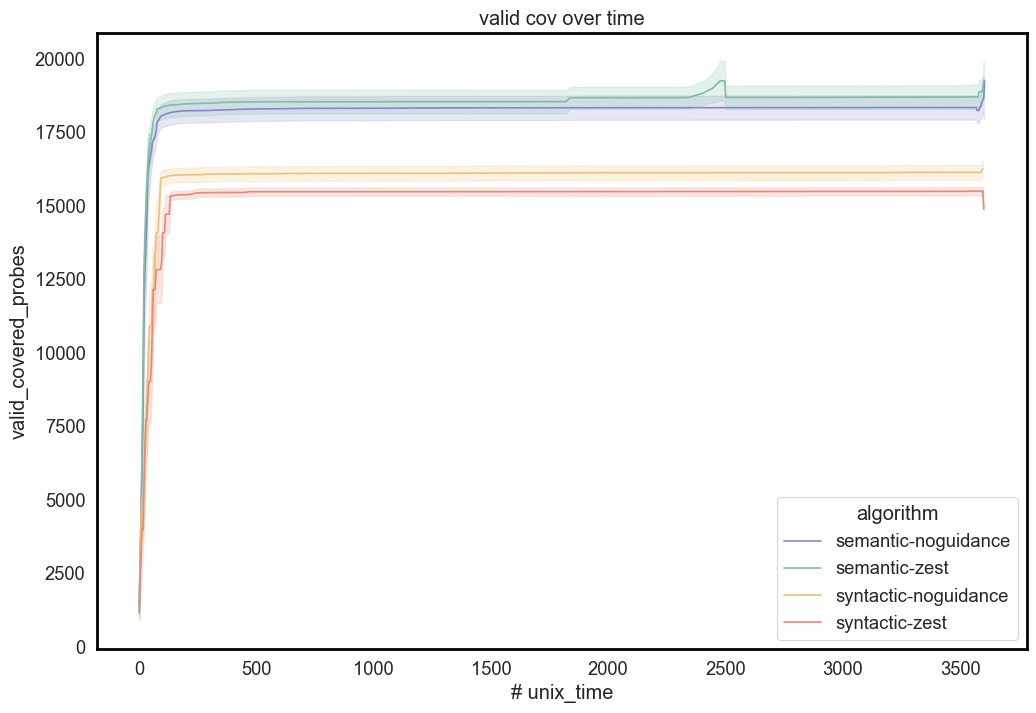

In [15]:
errorbrar = 'se'
pdf_dir=f'pdfs_{folder}/'

if not os.path.exists(os.path.join(".",pdf_dir)):
    os.mkdir(os.path.join(".",pdf_dir))

generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "valid_covered_probes", f"{pdf_dir}valid_cov_over_time.pdf", errorbrar)
    

# unix_time all_covered_probes


C:\Users\Alena\AppData\Local\Temp\ipykernel_8236\3343039859.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


# unix_time total_inputs


C:\Users\Alena\AppData\Local\Temp\ipykernel_8236\3343039859.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


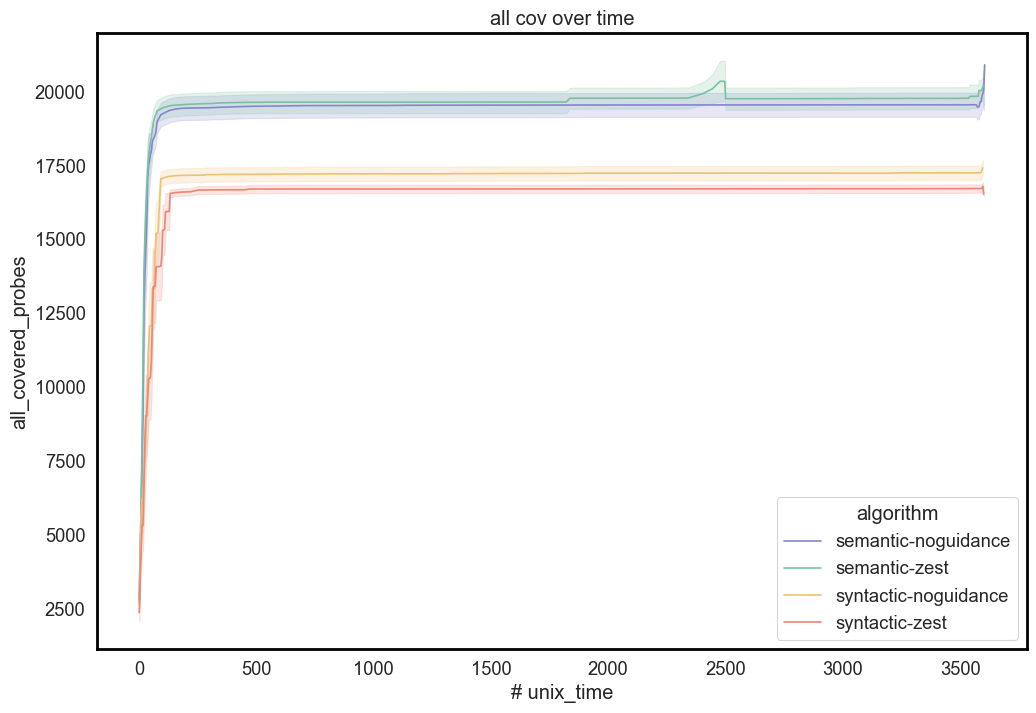

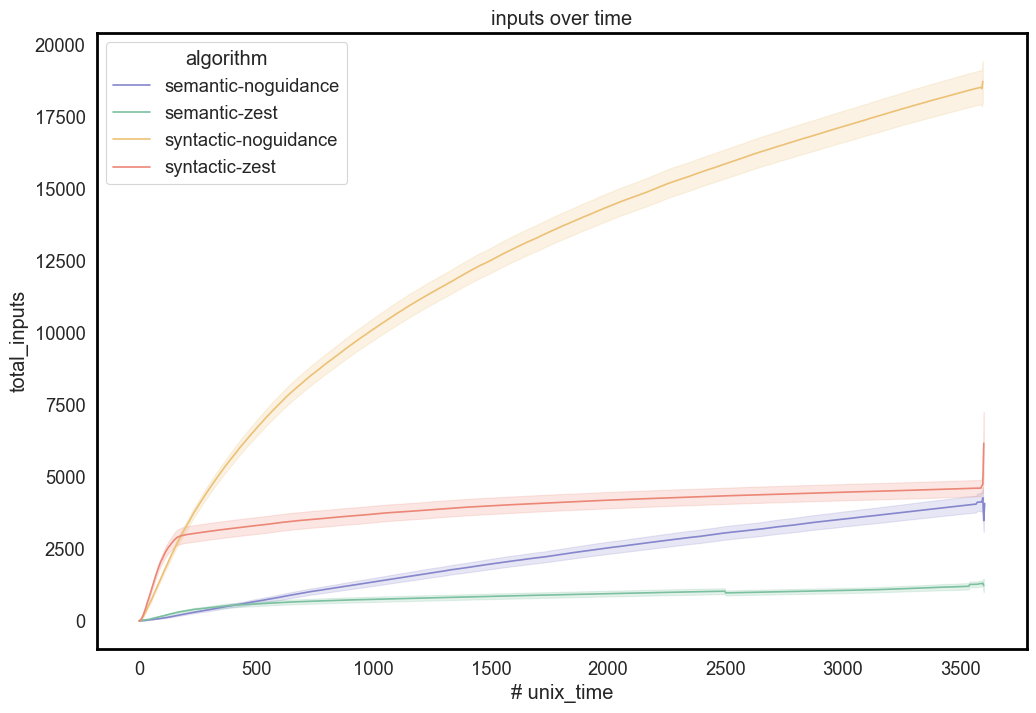

In [16]:
generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "all_covered_probes", f"{pdf_dir}all_cov_over_time.pdf", errorbrar)
generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "total_inputs" , f"{pdf_dir}inputs_over_time.pdf", errorbrar)


# unix_time valid_inputs


C:\Users\Alena\AppData\Local\Temp\ipykernel_8236\3343039859.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


# unix_time invalid_inputs


C:\Users\Alena\AppData\Local\Temp\ipykernel_8236\3343039859.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


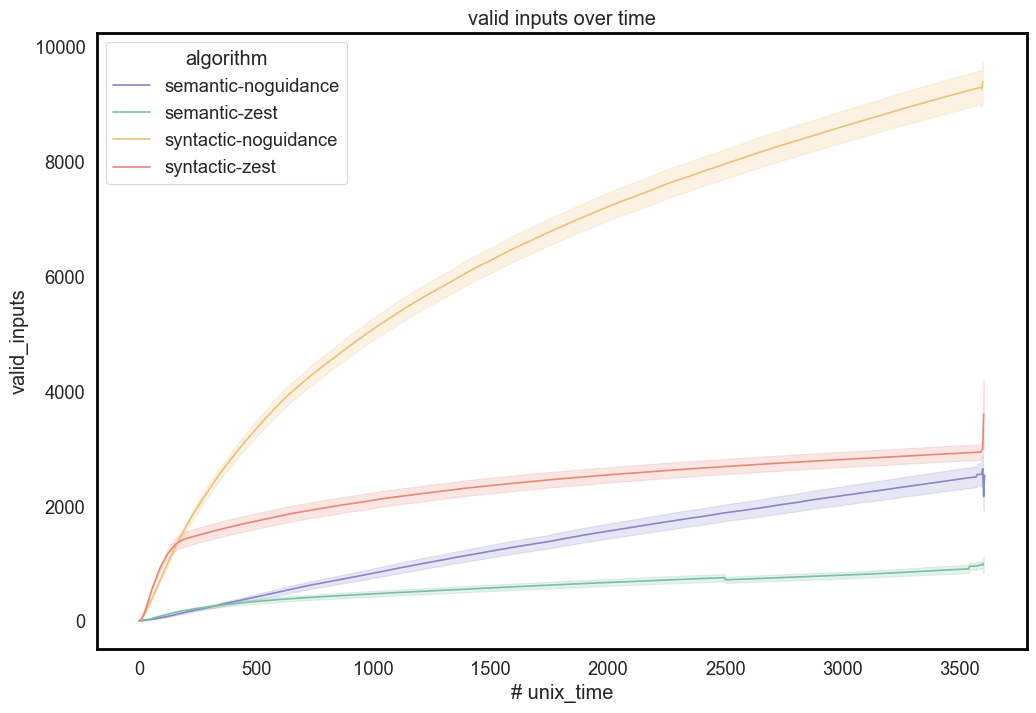

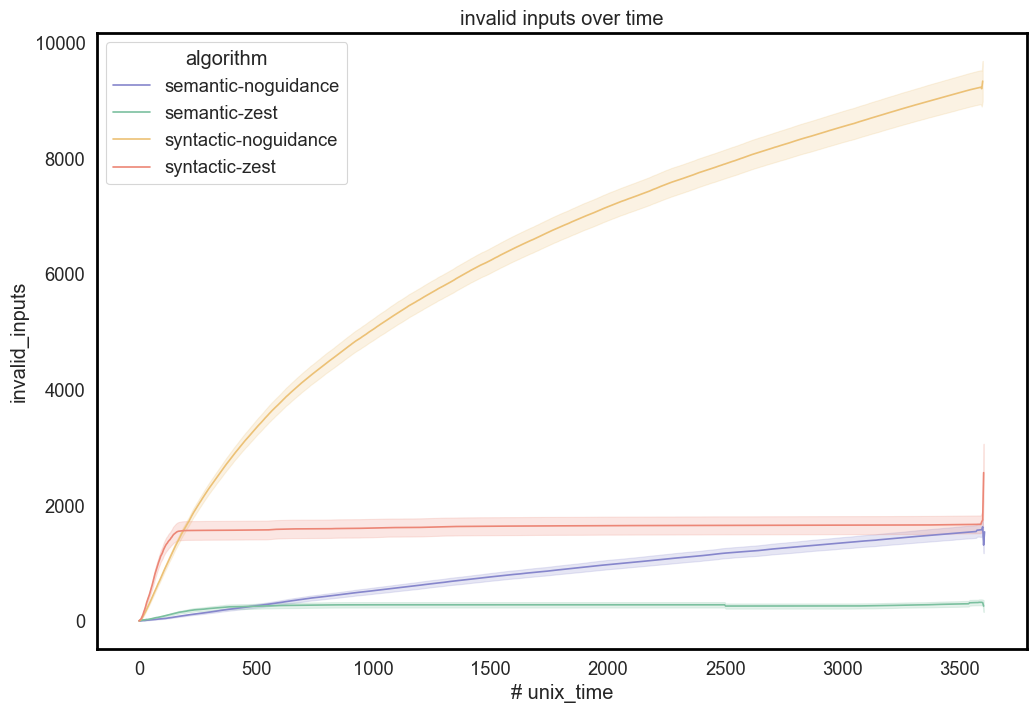

In [17]:
generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "valid_inputs" , f"{pdf_dir}valid_inputs_over_time.pdf", errorbrar)
generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "invalid_inputs" , f"{pdf_dir}invalid_inputs_over_time.pdf", errorbrar)


In [18]:
#sns.pairplot(rolling_time_based_plot_data)

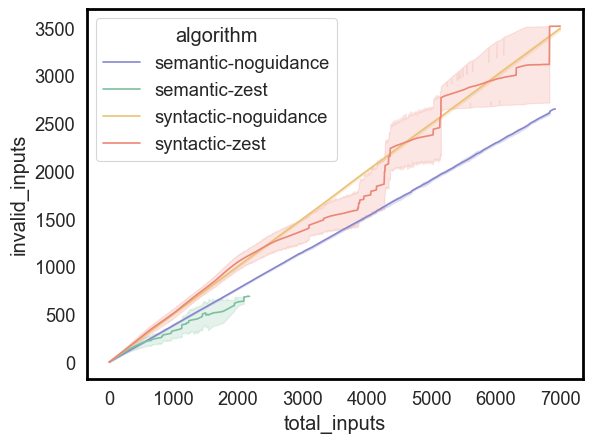

In [19]:
small_count_based_plot_data = count_based_plot_data[count_based_plot_data['total_inputs']<7000]

plot= sns.lineplot(small_count_based_plot_data, 
                 x='total_inputs',
                 y='invalid_inputs',
                 hue='algorithm', 
                 hue_order=sorted(rolling_time_based_plot_data['algorithm'].unique()))

In [20]:
plot.get_figure().savefig(f"{pdf_dir}invalid_over_inputs.pdf")

total_inputs valid_covered_probes


C:\Users\Alena\AppData\Local\Temp\ipykernel_8236\3343039859.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


total_inputs all_covered_probes


C:\Users\Alena\AppData\Local\Temp\ipykernel_8236\3343039859.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


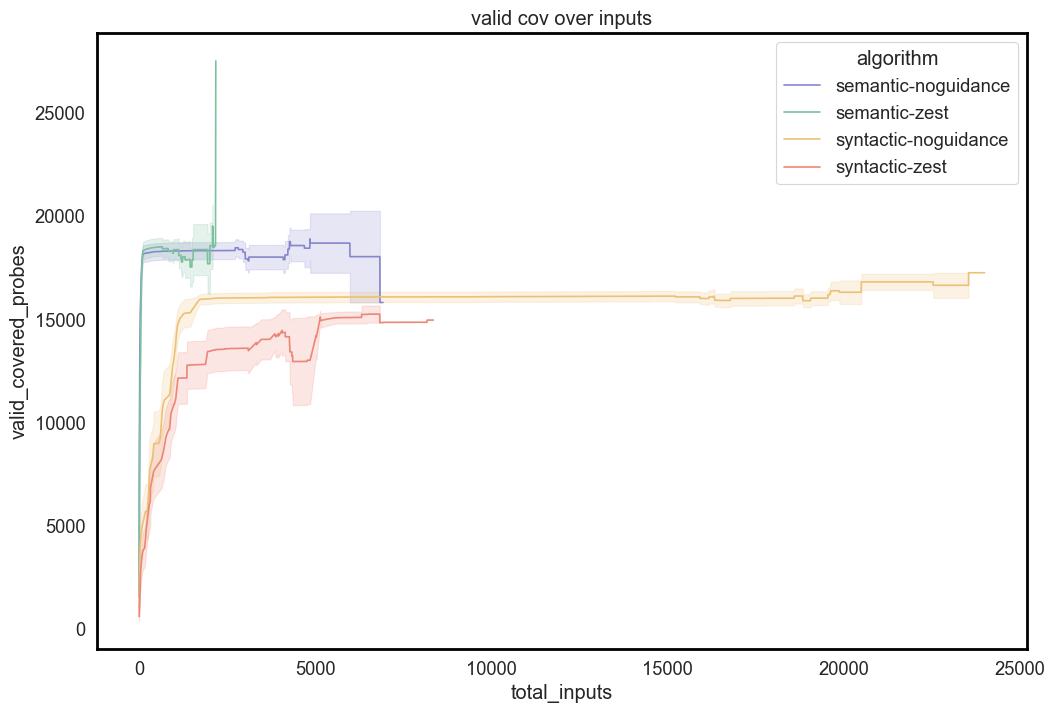

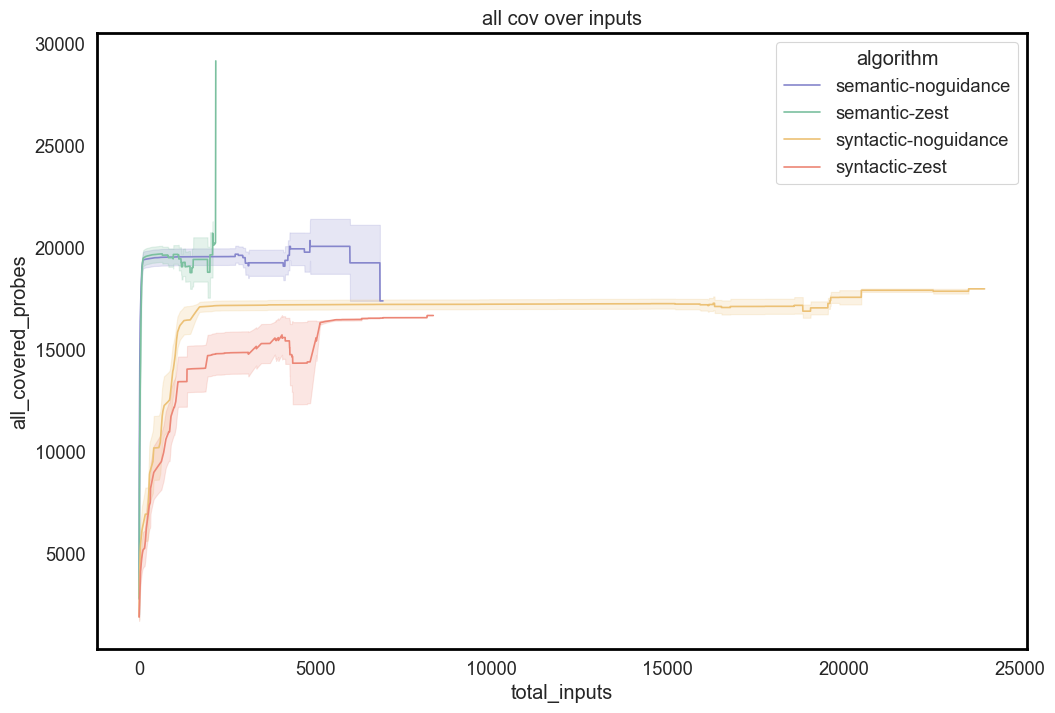

In [21]:

generate_plot_data_base(count_based_plot_data, rolling_count_based_plot_data, "total_inputs", "valid_covered_probes", f"{pdf_dir}valid_cov_over_inputs.pdf", errorbrar)
generate_plot_data_base(count_based_plot_data, rolling_count_based_plot_data, "total_inputs", "all_covered_probes", f"{pdf_dir}all_cov_over_inputs.pdf", errorbrar)


# unix_time unique_crashes


C:\Users\Alena\AppData\Local\Temp\ipykernel_8236\3343039859.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


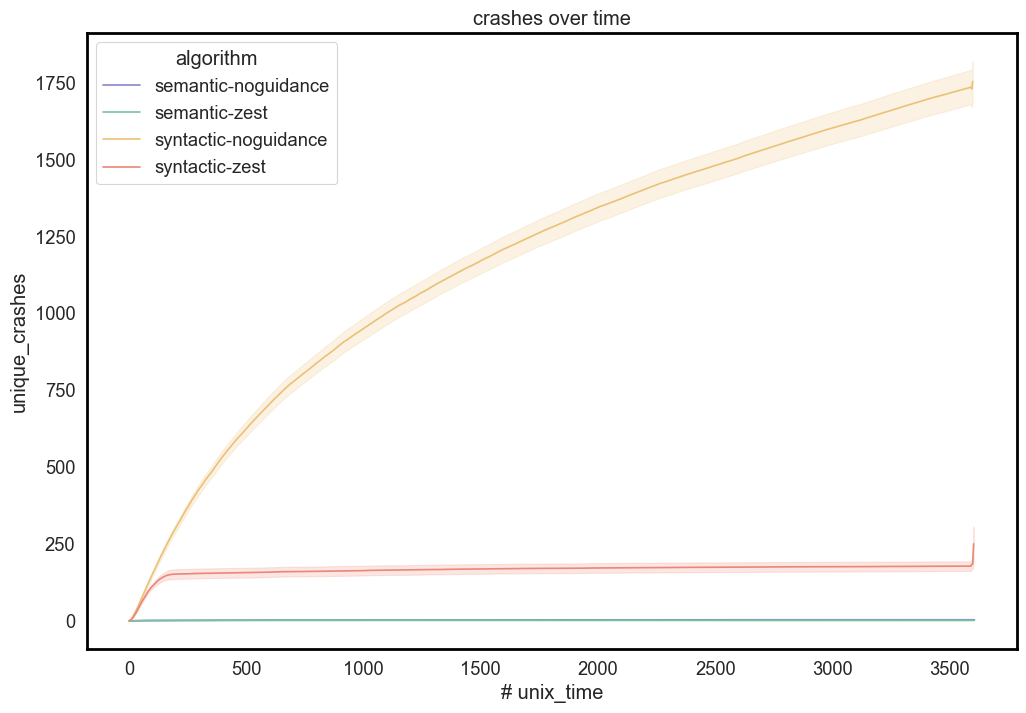

In [22]:
#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "valid_inputs", f"{pdf_dir}all_cov_over_time.pdf", errorbrar)

generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "unique_crashes", f"{pdf_dir}crashes_over_time.pdf", errorbrar)


In [23]:
exceptions_data[10:100]


,exception,unique,count,file,empty,algorithm
2,nextflow.exception.ScriptCompilationException,True,2,out1694884404428.nf,NaN,semantic-zest
3,nextflow.exception.ScriptCompilationException,True,3,out1694884609759.nf,NaN,semantic-zest
4,nextflow.exception.ScriptCompilationException,True,4,out1694884728304.nf,NaN,semantic-zest
0,nextflow.exception.AbortRunException,True,1,out1694886183368.nf,NaN,semantic-zest
1,nextflow.exception.ScriptCompilationException,True,1,out1694886217752.nf,NaN,semantic-zest
...,...,...,...,...,...,...
36,groovy.lang.MissingPropertyException,True,30,out1694866719257.nf,NaN,syntactic-zest
37,nextflow.exception.ScriptCompilationException,True,6,out1694866719526.nf,NaN,syntactic-zest
38,nextflow.exception.ScriptCompilationException,True,7,out1694866719805.nf,NaN,syntactic-zest
39,groovy.lang.MissingPropertyException,True,31,out1694866720634.nf,NaN,syntactic-zest


C:\Users\Alena\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Alena\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


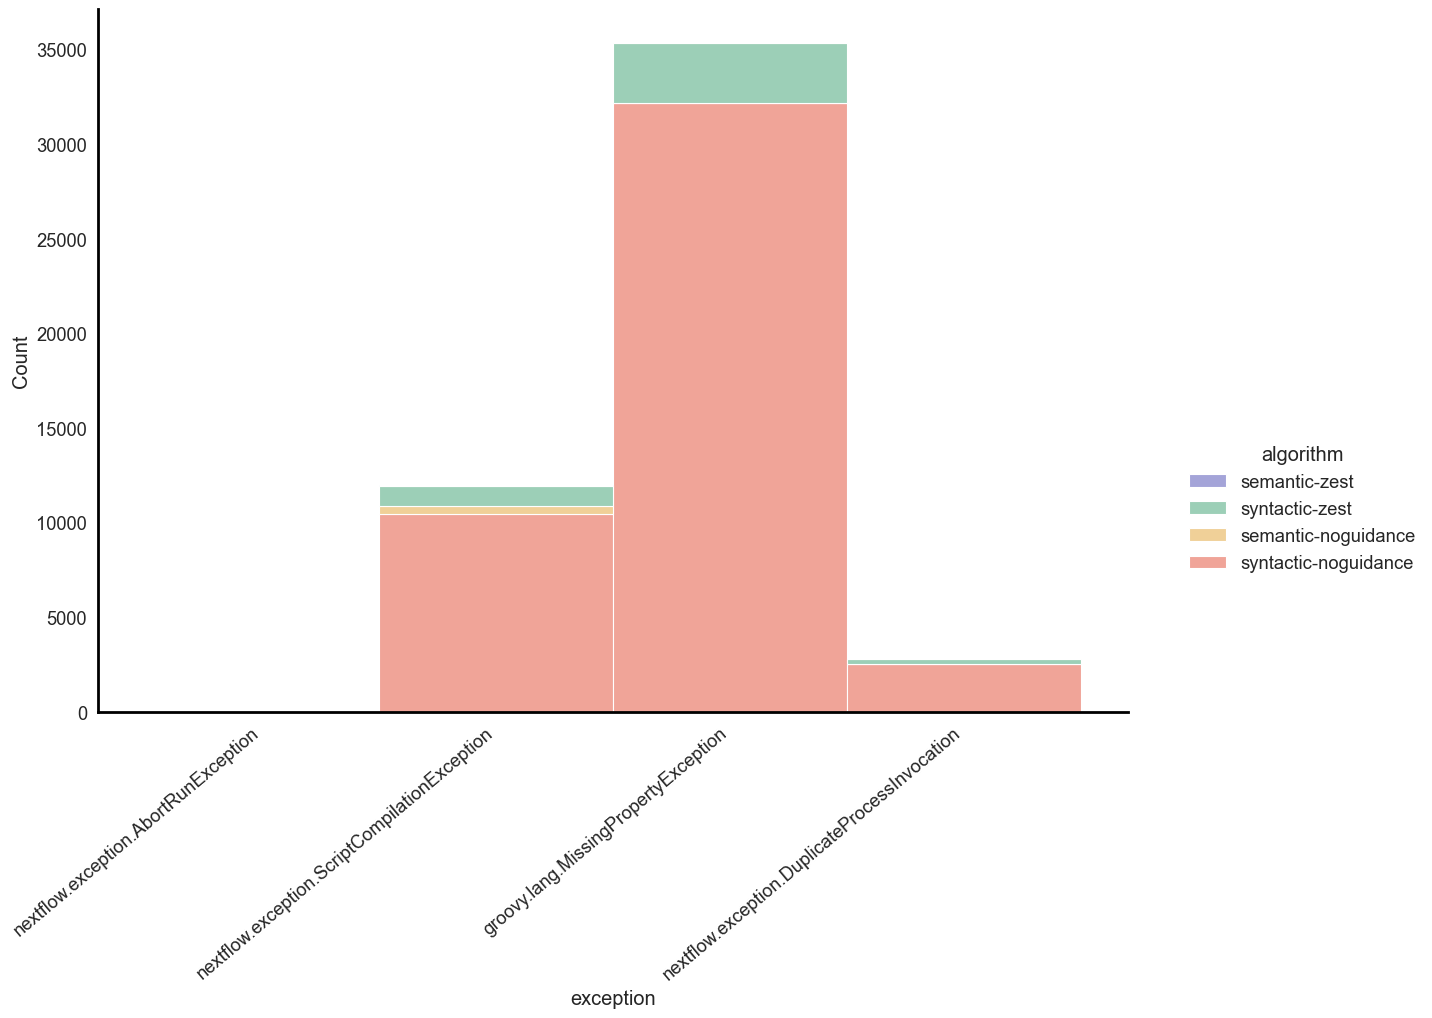

In [24]:
unique=exceptions_data[exceptions_data['unique'] == True]
#unique = unique[unique['algorithm'].isin(['semantic-noguidance','semantic-zest'])]
plot=sns.displot(unique, x='exception',hue='algorithm', height=8, aspect=1.5, multiple="stack")
plot.tight_layout()

for ax in plot.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(40)
        label.set_ha('right')

plot.savefig(f'{pdf_dir}/exceptions.pdf')

In [25]:
plot.savefig((os.path.join( pdf_dir, "exceptions_logged.pdf" )))

C:\Users\Alena\AppData\Local\Temp\ipykernel_8236\304718486.py:10: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  plot = sns.lineplot(data=unique,
C:\Users\Alena\AppData\Local\Temp\ipykernel_8236\304718486.py:17: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  plot2 = sns.lineplot(data=unique,
C:\Users\Alena\AppData\Local\Temp\ipykernel_8236\304718486.py:10: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  plot = sns.lineplot(data=unique,
C:\Users\Alena\AppData\Local\Temp\ipykernel_8236\304718486.py:17: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  plot2 = sns.lineplot(data=unique,
C:\Users\Alena\AppData\Local\Temp\ipykernel_8236\304718486.py:10: UserWarning: 
Th

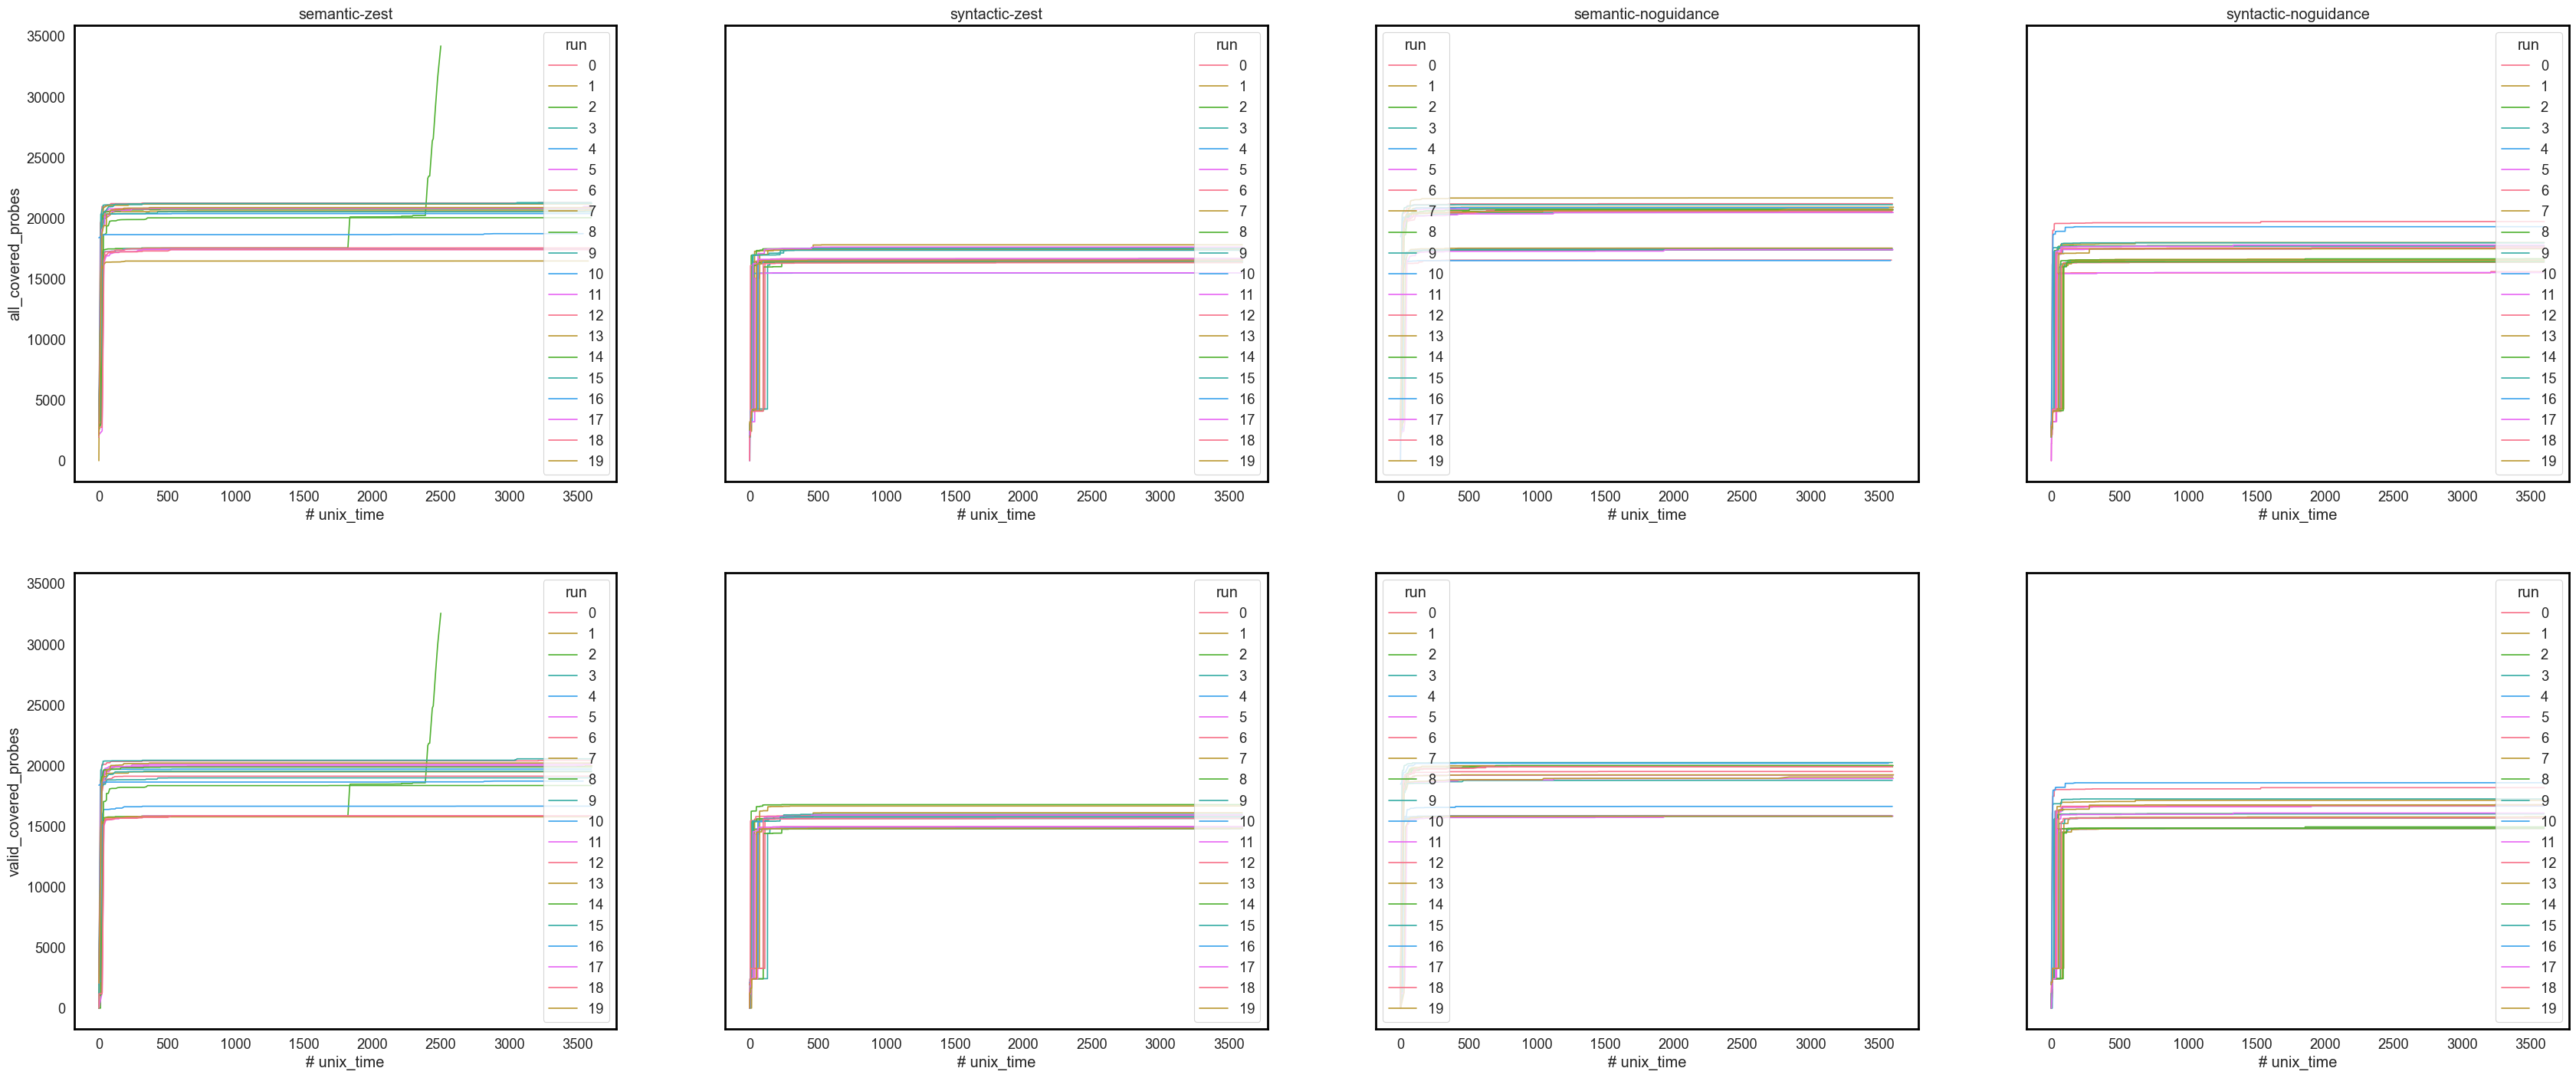

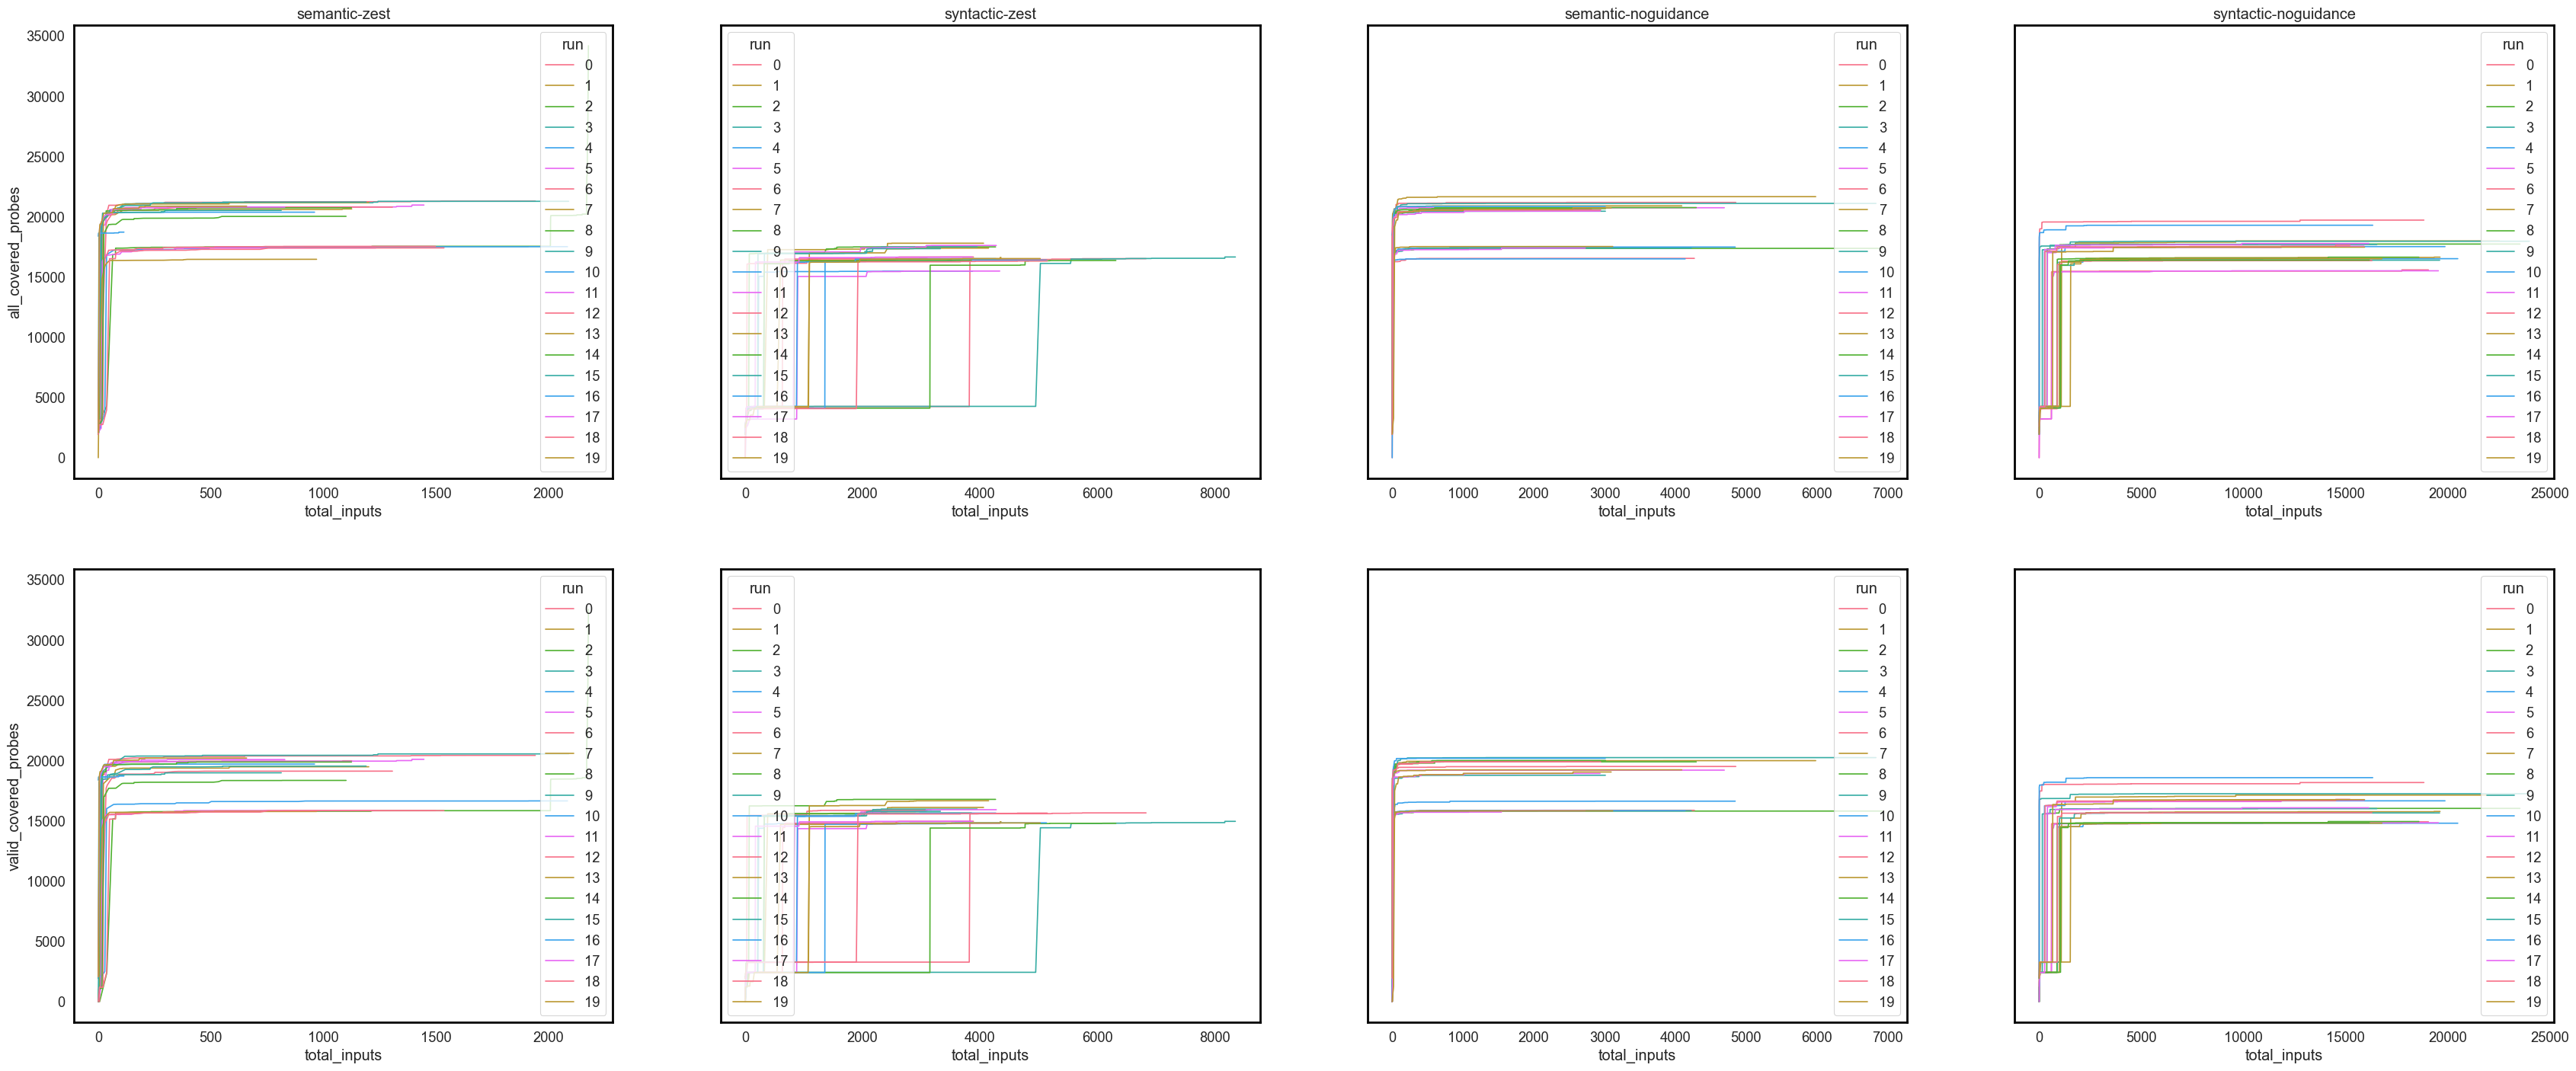

In [26]:
#unique = unique[unique['algorithm'].isin(['semantic-noguidance','semantic-zest'])]
l, axes = plt.subplots(2,4, figsize=(42,17),sharey=True)
i=0
cols = sns.color_palette("husl")

for algo in ALGORITHM:

    unique=rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'] == algo]
    if not unique.empty: 
        plot = sns.lineplot(data=unique, 
                  x='# unix_time',
                  y='all_covered_probes' ,
                  hue='run',
                  hue_order=sorted(unique['run'].unique()),
                  ax=axes[0,i],
                  palette=cols)
        plot2 = sns.lineplot(data=unique, 
                  x='# unix_time',
                  y='valid_covered_probes' ,
                  hue='run',
                  hue_order=sorted(unique['run'].unique()),
                  ax=axes[1,i],
                  palette=cols)
        plot.set_title(algo)
    i+=1


#unique = unique[unique['algorithm'].isin(['semantic-noguidance','semantic-zest'])]
l2, axes2 = plt.subplots(2,4, figsize=(42, 17),sharey=True)
i=0

for algo in ALGORITHM:

    unique=rolling_count_based_plot_data[rolling_count_based_plot_data['algorithm'] == algo]
    if not unique.empty: 
        plot = sns.lineplot(data=unique, 
                  x='total_inputs',
                  y='all_covered_probes' ,
                  hue='run',
                  hue_order=sorted(unique['run'].unique()),
                  ax=axes2[0,i],
                  palette=cols)
        plot2 = sns.lineplot(data=unique, 
                  x='total_inputs',
                  y='valid_covered_probes' ,
                  hue='run',
                  hue_order=sorted(unique['run'].unique()),
                  ax=axes2[1,i],
                  palette=cols)
        plot.set_title(algo)
    i+=1




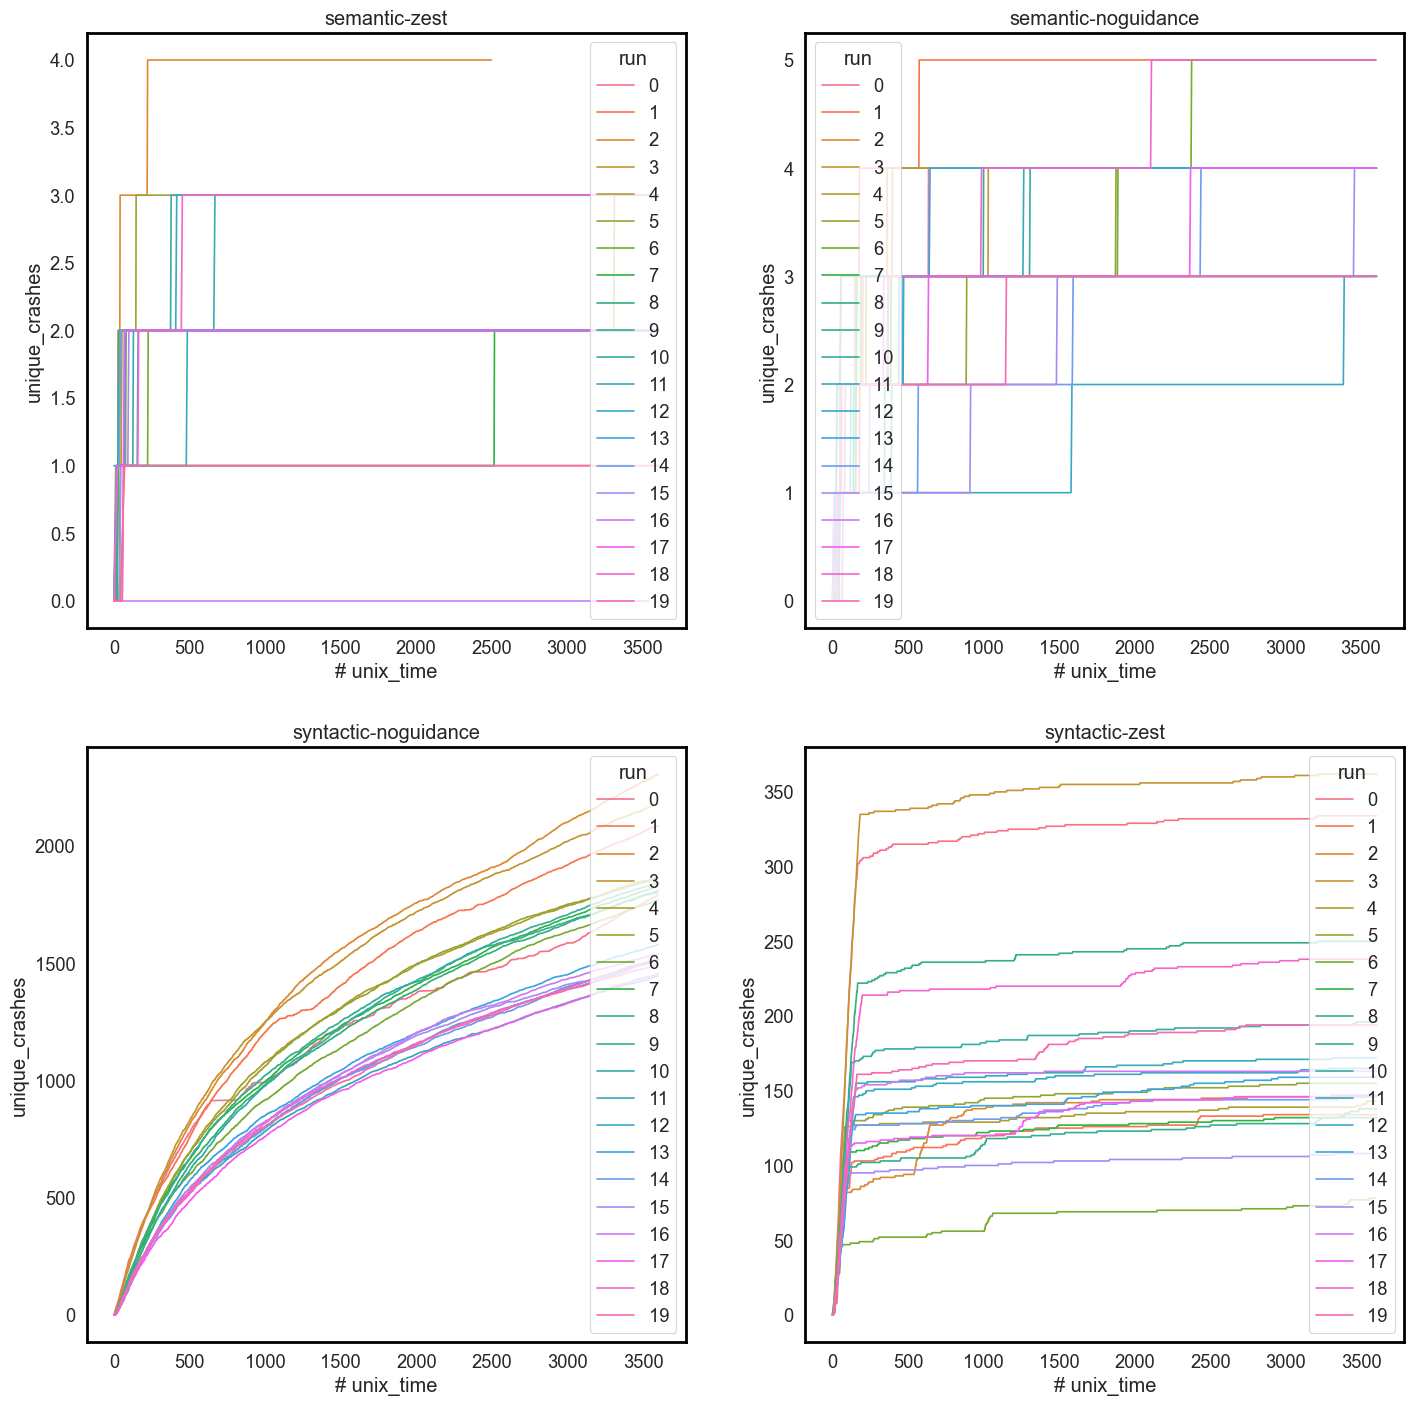

In [27]:
#unique = unique[unique['algorithm'].isin(['semantic-noguidance','semantic-zest'])]
l, axes = plt.subplots(2,2, figsize=(17,17),sharey=False)
i=0
cols = sns.color_palette("husl",20)

algo = 'semantic-zest'
unique=rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'] == algo]
if not unique.empty: 
    plot = sns.lineplot(data=unique, 
              x='# unix_time',
              y='unique_crashes' ,
              hue='run',
              hue_order=sorted(unique['run'].unique()),
              ax=axes[0,0],
                  palette=cols)
    plot.set_title(algo)

algo = 'semantic-noguidance'
unique=rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'] == algo]
if not unique.empty: 
    plot = sns.lineplot(data=unique, 
              x='# unix_time',
              y='unique_crashes' ,
              hue='run',
              hue_order=sorted(unique['run'].unique()),
              ax=axes[0,1],
                  palette=cols)
    plot.set_title(algo)


algo = 'syntactic-noguidance'
unique=rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'] == algo]
if not unique.empty: 
    plot = sns.lineplot(data=unique, 
              x='# unix_time',
              y='unique_crashes' ,
              hue='run',
              hue_order=sorted(unique['run'].unique()),
              ax=axes[1,0],
                  palette=cols)
    plot.set_title(algo)


algo = 'syntactic-zest'
unique=rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'] == algo]
if not unique.empty: 
    plot = sns.lineplot(data=unique, 
              x='# unix_time',
              y='unique_crashes' ,
              hue='run',
              hue_order=sorted(unique['run'].unique()),
              ax=axes[1,1],
                  palette=cols)
    plot.set_title(algo)



In [28]:
l.savefig(os.path.join( pdf_dir, "unique_crashes_per_run.pdf" ))

C:\Users\Alena\AppData\Local\Temp\ipykernel_8236\391615785.py:10: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  plot = sns.lineplot(data=unique,
C:\Users\Alena\AppData\Local\Temp\ipykernel_8236\391615785.py:10: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  plot = sns.lineplot(data=unique,
C:\Users\Alena\AppData\Local\Temp\ipykernel_8236\391615785.py:10: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  plot = sns.lineplot(data=unique,
C:\Users\Alena\AppData\Local\Temp\ipykernel_8236\391615785.py:10: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  plot = sns.lineplot(data=unique,


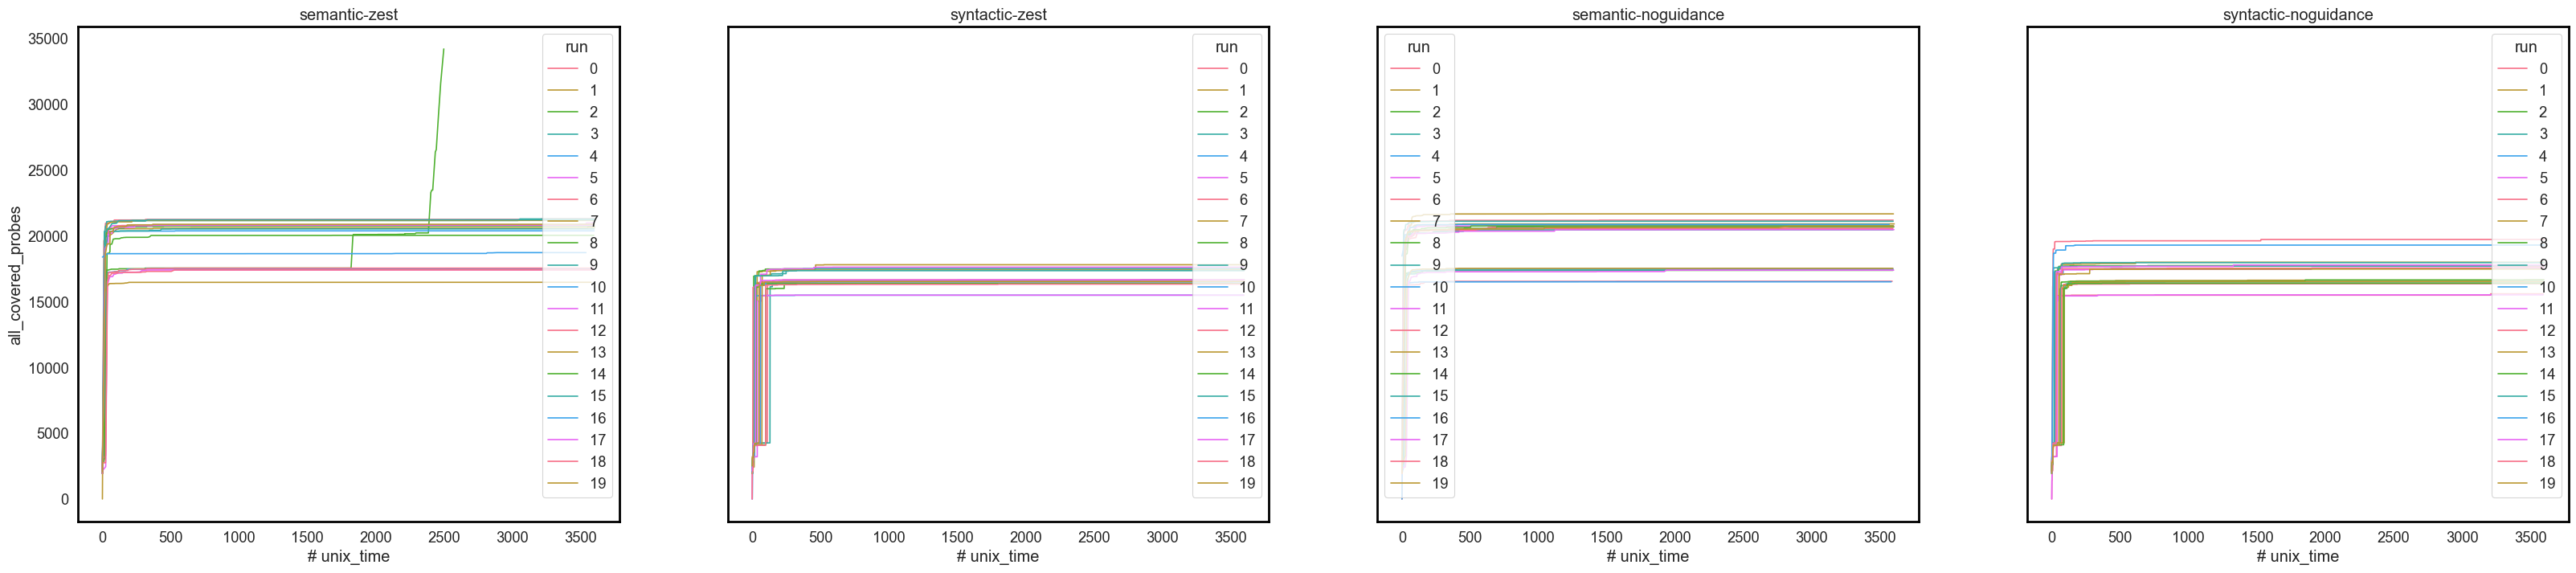

In [34]:
#unique = unique[unique['algorithm'].isin(['semantic-noguidance','semantic-zest'])]
l, axes = plt.subplots(1,4, figsize=(40,8),sharey=True)
i=0
cols = sns.color_palette("husl")

for algo in ALGORITHM:

    unique=rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'] == algo]
    if not unique.empty: 
        plot = sns.lineplot(data=unique, 
                  x='# unix_time',
                  y='all_covered_probes' ,
                  hue='run',
                  hue_order=sorted(unique['run'].unique()),
                  ax=axes[i],
                  palette=cols)
        plot.set_title(algo)
    i+=1
l.savefig(os.path.join( pdf_dir, "cov_per_run.pdf" ))
